# Support Vector Machines

## Case Study: Face Recognition (Using inbuilt data set)

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [1]:
import sklearn.datasets as dt

In [2]:
dt.fetch_lfw_people

<function sklearn.datasets.lfw.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True)>

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

In [4]:
import pandas as pd

In [5]:
print(faces.images)

[[[138.         135.66667    127.666664   ...  69.          68.333336
    67.333336  ]
  [146.         139.33333    125.         ...  68.333336    67.666664
    67.333336  ]
  [150.         138.33333    124.333336   ...  68.333336    67.666664
    66.666664  ]
  ...
  [153.         174.         110.666664   ...   1.6666666    0.6666667
     0.6666667 ]
  [122.         193.         167.33333    ...   1.3333334    1.6666666
     1.3333334 ]
  [ 88.         177.33333    206.         ...   1.6666666    1.6666666
     0.33333334]]

 [[ 71.333336    56.          67.666664   ...  74.333336    89.666664
    78.666664  ]
  [ 64.333336    61.666668    84.333336   ...  72.          87.
    78.666664  ]
  [ 74.          76.          94.333336   ...  69.666664    84.666664
    83.333336  ]
  ...
  [ 28.333334    26.666666    20.666666   ... 242.         236.33333
   232.        ]
  [ 24.          20.666666    18.666666   ... 247.         242.33333
   238.33333   ]
  [ 19.666666    14.666667    16.6

In [7]:
faces.images[2]

array([[ 84.333336,  97.333336,  72.333336, ...,  82.666664,  51.      ,
         71.333336],
       [ 98.333336, 101.      ,  75.      , ..., 100.      ,  54.666668,
         60.666668],
       [104.666664, 100.      ,  76.      , ..., 110.666664,  67.      ,
         62.666668],
       ...,
       [ 56.      ,  56.333332,  55.      , ...,  91.      , 106.666664,
        204.66667 ],
       [ 58.333332,  58.      ,  56.666668, ...,  90.666664, 140.      ,
        226.      ],
       [ 61.666668,  63.      ,  63.333332, ..., 114.      , 194.33333 ,
        241.      ]], dtype=float32)

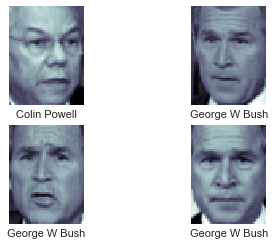

In [12]:
fig, ax = plt.subplots(2, 2)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [16]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [17]:
SVC?

In [19]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [20]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [22]:
GridSearchCV?

In [23]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=5)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 49.9 s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [24]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [25]:
yfit

array([3, 4, 3, 6, 6, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 1, 7, 2, 3, 2, 7, 7,
       5, 5, 0, 3, 6, 7, 3, 3, 0, 6, 3, 3, 2, 3, 2, 3, 3, 0, 3, 3, 7, 1,
       3, 3, 0, 2, 1, 2, 7, 3, 4, 6, 7, 3, 7, 1, 7, 0, 4, 2, 7, 2, 5, 4,
       7, 3, 4, 5, 1, 5, 4, 1, 3, 4, 0, 4, 3, 3, 1, 3, 1, 0, 3, 2, 3, 2,
       7, 1, 1, 1, 2, 7, 3, 1, 7, 3, 3, 1, 3, 7, 1, 4, 3, 3, 0, 3, 7, 0,
       3, 1, 0, 7, 7, 1, 3, 2, 7, 4, 7, 7, 5, 2, 3, 1, 3, 3, 2, 2, 3, 7,
       0, 3, 4, 3, 4, 1, 2, 1, 7, 6, 5, 3, 3, 1, 1, 3, 5, 4, 3, 2, 7, 1,
       7, 1, 3, 0, 1, 4, 6, 1, 2, 3, 2, 3, 1, 7, 2, 2, 1, 7, 3, 3, 1, 1,
       1, 3, 3, 0, 0, 4, 1, 1, 7, 1, 1, 5, 3, 4, 3, 3, 4, 5, 6, 3, 7, 4,
       3, 2, 0, 3, 2, 3, 3, 6, 3, 3, 1, 7, 3, 6, 1, 2, 3, 1, 1, 7, 6, 3,
       1, 3, 1, 7, 7, 2, 7, 7, 5, 7, 1, 3, 3, 7, 4, 4, 7, 2, 3, 1, 3, 4,
       4, 1, 4, 3, 1, 1, 5, 1, 2, 3, 4, 1, 1, 1, 2, 2, 3, 7, 3, 7, 3, 7,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 4, 4, 3, 1, 4, 1, 4, 0, 3, 2, 0,
       4, 5, 1, 3, 3, 6, 2, 2, 3, 6, 7, 1, 1, 5, 1,

Let's take a look at a few of the test images along with their predicted values:

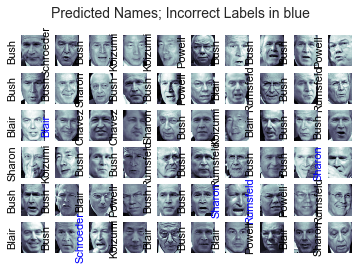

In [27]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'blue')
fig.suptitle('Predicted Names; Incorrect Labels in blue', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [28]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.82      0.88      0.85        68
  Donald Rumsfeld       0.76      0.84      0.80        31
    George W Bush       0.97      0.81      0.88       126
Gerhard Schroeder       0.69      0.87      0.77        23
      Hugo Chavez       0.88      0.70      0.78        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.89      0.98      0.93        42

      avg / total       0.87      0.85      0.86       337



We might also display the confusion matrix between these classes:

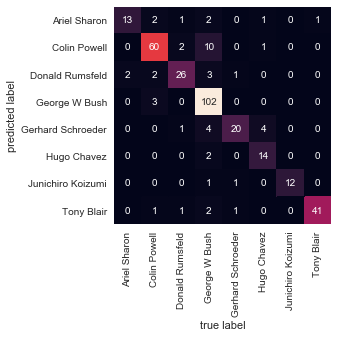

In [29]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

# Pros and Cons
### Pros
- It works really well with clear margin of separation
- It is effective with large number of features.
- It is effective in cases where number of dimensions is greater than the number of samples.
- Memory Efficient

## Cons
- It doesn’t perform well, when we have large data set because the required training time is higher
- It also doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping
- SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. It is related SVC method of Python scikit-learn library.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

### Tips on Usage
- The linear kernel is best for a large dataset (N>1000) since  it is more likely that the data is linearly separable in high dimensional space. 
- When using the rbf kernel, cross validate for gamma and C